# Embedding multimodal data for similarity search using 🤗 transformers, 🤗 datasets and FAISS

_Authored by: [Merve Noyan](https://huggingface.co/merve)_

Embeddings are semantically meaningful compressions of information. They can be used to do similarity search, zero-shot classification or simply train a new model. Use cases for similarity search include searching for similar products in e-commerce, content search in social media and more.
This notebook walks you through using 🤗transformers, 🤗datasets and FAISS to create and index embeddings from a feature extraction model to later use them for similarity search.
Let's install necessary libraries.

In [ ]:
!pip install -q datasets faiss-gpu transformers sentencepiece

For this tutorial, we will use [CLIP model](https://huggingface.co/openai/clip-vit-base-patch16) to extract the features. CLIP is a revolutionary model that introduced joint training of a text encoder and an image encoder to connect two modalities.

In [1]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Load the dataset. To keep this notebook light, we will use a small captioning dataset, [jmhessel/newyorker_caption_contest](https://huggingface.co/datasets/jmhessel/newyorker_caption_contest).

In [2]:
from datasets import load_dataset

ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

Generating train split:   0%|          | 0/2340 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

See an example.

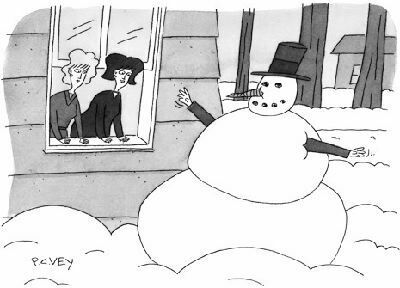

In [3]:
ds["train"][0]["image"]

In [4]:
ds["train"][0]["image_description"]

'Two women are looking out a window. There is snow outside, and there is a snowman with human arms.'

We don't have to write any function to embed examples or create an index. 🤗 datasets library's FAISS integration abstracts these processes. We can simply use `map` method of the dataset to create a new column with the embeddings for each example like below. Let's create one for text features on the prompt column.

In [5]:
dataset = ds["train"]
ds_with_embeddings = dataset.map(lambda example:
                                {'embeddings': model.get_text_features(
                                    **tokenizer([example["image_description"]],
                                                truncation=True, return_tensors="pt")
                                    .to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [6]:
ds_with_embeddings.add_faiss_index(column='embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings'],
    num_rows: 2340
})

We can do the same and get the image embeddings.

In [7]:
ds_with_embeddings = ds_with_embeddings.map(lambda example:
                                          {'image_embeddings': model.get_image_features(
                                              **processor([example["image"]], return_tensors="pt")
                                              .to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [8]:
ds_with_embeddings.add_faiss_index(column='image_embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings', 'image_embeddings'],
    num_rows: 2340
})

## Querying the data with text prompts

We can now query the dataset with text or image to get similar items from it.

In [14]:
prmt = "a windy day"
prmt_embedding = model.get_text_features(**tokenizer([prmt], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('image_embeddings', prmt_embedding, k=1)

['Some people are flying kites at the park. A police officer with keys is talking to one of them.']


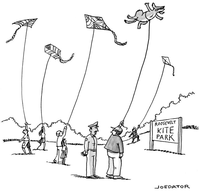

In [15]:
def downscale_images(image):
  width = 200
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  return img

images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])



## Querying the data with image prompts

Image similarity inference is similar, where you just call `get_image_features`.

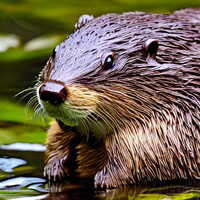

In [16]:
import requests
# image of a beaver
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/beaver.png"
image = Image.open(requests.get(url, stream=True).raw)
display(downscale_images(image))

Search for the similar image.

In [17]:
img_embedding = model.get_image_features(**processor([image], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('image_embeddings', img_embedding, k=1)

Unused or unrecognized kwargs: truncation.


Display the most similar image to the beaver image.

['Salmon swim upstream but they see a grizzly bear and are in shock. The bear has a smug look on his face when he sees the salmon.']


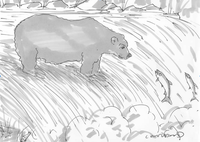

In [18]:
images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])

## Saving, pushing and loading the embeddings
We can save the dataset with embeddings with `save_faiss_index`.


In [20]:
ds_with_embeddings.save_faiss_index('image_embeddings', 'embeddings/embeddings.faiss')

In [21]:
ds_with_embeddings.save_faiss_index('image_embeddings', 'embeddings/image_embeddings.faiss')

It's a good practice to store the embeddings in a dataset repository, so we will create one and push our embeddings there to pull later.
We will login to Hugging Face Hub, create a dataset repository there and push our indexes there and load using `snapshot_download`.

In [22]:
from huggingface_hub import HfApi, notebook_login, snapshot_download
notebook_login()

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.create_repo("merve/faiss_embeddings", repo_type="dataset")
api.upload_folder(
    folder_path="./embeddings",
    repo_id="merve/faiss_embeddings",
    repo_type="dataset",
)

In [ ]:
snapshot_download(repo_id="merve/faiss_embeddings", repo_type="dataset",
                  local_dir="downloaded_embeddings")

  We can load the embeddings to the dataset with no embeddings using `load_faiss_index`.

In [ ]:
ds = ds["train"]
ds.load_faiss_index('embeddings', './downloaded_embeddings/embeddings.faiss')
# infer again
prmt = "people under the rain"


In [ ]:
prmt_embedding = model.get_text_features(
                        **tokenizer([prmt], return_tensors="pt", truncation=True)
                        .to("cuda"))[0].detach().cpu().numpy()

scores, retrieved_examples = ds.get_nearest_examples('embeddings', prmt_embedding, k=1)

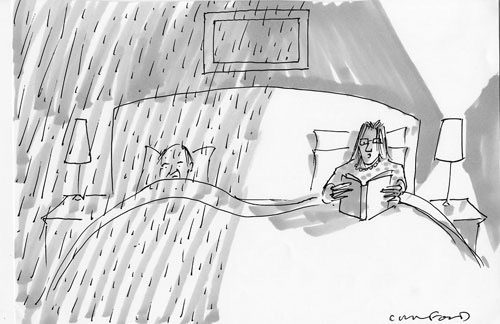

In [ ]:
display(retrieved_examples["image"][0])